In [1]:
## Homework 5 MassProfile
## Ezekiel Dong

In [2]:
# import all modules we need in the following code
import numpy as np
import astropy.units as u
import astropy.table as tbl

from ReadFile import Read
from CenterOfMass import CenterOfMass
from astropy.constants import G # need G in circular velocity
from matplotlib import pyplot as plt

COM position and velocity for MW
[-0.87  2.39 -1.42] kpc
[-0.47  3.41 -1.33] km / s
COM position and velocity for M31
[-377.74  611.47 -284.61] kpc
[ 72.78 -71.91  48.7 ] km / s
COM position and velocity for M33
[-476.24  491.44 -412.4 ] kpc
[ 44.42 101.78 142.23] km / s
separation between MW and M31: 796.273 kpc
velocity between MW and M31: 179.725 km / s
separation between M33 and M31: 201.096 kpc
velocity between M33 and M31: 199.3 km / s


In [3]:
class MassProfile:
    '''
    class to find mass profile, circular velocity and rotation curve
    '''
    def __init__(self, galaxy, snap):
        '''
        Goal:
            this function is designed to initialze the class
        
        Input:
            galaxy(str)--name of galaxies
            snap(int)--snapshot number
        '''
        
        
        # add a string of the filenumber to the value “000” 
        ilbl = '000' + str(snap)
        # remove all but the last 3 digits
        ilbl = ilbl[-3:]
        self.filename = '%s_' % (galaxy) + ilbl + '.txt'
        
        # read data in the given file using Read
        self.time, self.total_particles, self.data = Read(self.filename)
        
        # store the mass, positions, velocities of only the particles of the given type
        # use approriate unit
        self.m = self.data['m'] * 1e10
        self.x = self.data['x'] * u.kpc
        self.y = self.data['y'] * u.kpc
        self.z = self.data['z'] * u.kpc
    
        # Store the name of the galaxy as a global property
        self.gname = galaxy
    
    def MassEnclosed(self, particle_type, radii):
        '''
        Goal:
            this function is designed to calculatet the mass with in desired radii
            
        Input:
            particle_type(int)--the type of particle
            radii(array)--numpy array of radii
        
        Output:
            mass_enclosed(array)--the array of enclosed mass of desired particles in desired range
        '''
        # determine the COM position by creating a CenterOfMass object and calling COM_P
        COM_particle = CenterOfMass.COM_P(CenterOfMass(self.filename, particle_type), 0.1)
        # use index store desired particle type
        index = np.where(self.data['type'] == particle_type)
        
        # find the mass of enclosed particle, create the result array
        self.m_enclosed = self.m[index]
        mass_enclosed = np.zeros(len(radii))# create an empty array
        for i in range(len(radii)):
            distance = np.sqrt((self.x[index] - COM_particle[0]) ** 2 + (self.y[index] - COM_particle[1]) ** 2 + (self.z[index] - COM_particle[2]) ** 2)
            
            # determine the enclosed index
            enclosed = np.where(distance < radii[i] * u.kpc)
            
            # calculate the enclosed mass
            mass_enclosed[i] = sum(self.m_enclosed[enclosed])
        # append unit and 1e10 to final result array
        
        mass_enclosed = mass_enclosed * 1e10 * u.Msun
        
        return mass_enclosed
    
    def Total_MassEnclosed(self, radii):
        '''
        Goal: 
            This function calculate the total mass of enclosed particle(any type) with desired galaxy
            
        Input:
            radii(array)--numpy array of radii
            
        Output:
            total_mass_enclosed(array)--an array of masses (in units of M⊙) representing the
                total enclosed mass (bulge+disk+halo) at each radius of the input array
        '''
        # type 1, 2 3 represent Halo, Disk and Bulge, M33 have no Bulge
        if self.gname == 'M33':
            total_mass_enclosed = self.MassEnclosed(1, radii) + self.MassEnclosed(2, radii)
        else:
            total_mass_enclosed = self.MassEnclosed(1, radii) + self.MassEnclosed(2, radii) + self.MassEnclosed(3, radii)
        return total_mass_enclosed
        
    def HernquistMass(self, radii, a, Mhalo):
        '''
        Goal: 
            This function will compute the mass enclosed within a given radius using the theoretical profile
            
        Input:
            radii(array)--numpy array of radii
            a(float)--scale factor
            Mhalo(float)--halo mass
            
        Output:
            enclosed_Mhalo(float)--enclosed halo mass in units of M⊙
        '''
        # since Mhalo already have unit, remove unit first, at end append unit for enclosed_Mhalo
        enclosed_Mhalo = ((Mhalo / u.kpc * radii ** 2) / ((a + radii) ** 2)) * u.Msun
        
        return enclosed_Mhalo
    
    def CircularVelocity(self, particle_type, radii, G):
        '''
        Goal: 
            This function will compute the rotation curve 
            
        Input:
            particle_type(int)--the type of particle
            radii(array)--numpy array of radii
            G(float)--gravitational constant
            
        Output:
            circular_velocity(array)--calculate the circular verlocity at desired radii of desired type
        '''
        # find enclosed mass and find circular speed, 2 decimal
        enclosed_mass = self.MassEnclosed(particle_type, radii)
        circular_velocity = np.round(np.sqrt(G * enclosed_mass / (radii * u.kpc)), 2)
        
        return circular_velocity
    
    def Total_CircularVelocity(self, radii):
        '''
        Goal: 
            This function will compute the rotation curve 
            
        Input:
            radii(array)--numpy array of radii
            
        Output:
            total_circular_velocity(array)--calculate the total circular verlocity at desired radii of any types
        '''
        if self.gname == 'M33':
            total_circular_velocity = self.CircularVelocity(1, radii, G) + self.CircularVelocity(2, radii, G)
        else:
            total_circular_velocity = self.CircularVelocity(1, radii, G) + self.CircularVelocity(2, radii, G) + self.CircularVelocity(3, radii, G)
        
        return total_circular_velocity
    
    def HernquistCircularVelocity(self, radii, a, Mhalo, G):
        '''
        Goal: 
            This function will compute circular speed using the Hernquist mass profile
            
        Input:
            radii(float)--radius
            a(float)--scale factor
            Mhalo(float)--halo mass
            G(float)--gravitational constant
            
        Output:
            enclosed_circular_velocity(float)--enclosed circular speed in units of km/s 
        '''
        
        enclosed_circular_velocity = np.round(no.sqrt(G * self.HernquistMass(radii, a, Mhalo)) / radii * u.kpc, 2)
        
        return enclosed_circular_velocity

# Mass Profile + Velocity Curve
Milkey Way

In [21]:
MW = MassProfile('MW', 0)# mw class
radii = np.arange(0.1, 30.1, 0.5)# radius range

# enclosed mass of MW by type and total
MW_enclosed_mass_Halo = MW.MassEnclosed(1, radii)
MW_enclosed_mass_Disk = MW.MassEnclosed(2, radii)
MW_enclosed_mass_Bulge = MW.MassEnclosed(3, radii)
MW_enclosed_mass_Total = MW.Total_MassEnclosed(radii)
MW_enclosed_mass_hernquist = MW.HernquistMass(radii, 0.1, MW_enclosed_mass_Halo)

# velocity profile
MW_velocity_Halo = MW.CircularVelocity(1,radii,G)
MW_velocity_Disk = MW.CircularVelocity(2,radii,G)
MW_velocity_Bulge = MW.CircularVelocity(3,radii,G)
MW_velocity_Total = MW.Total_CircularVelocity(radii)
MW_velocity_Hernquist = MW.HernquistCircularVelocity(radii, a, MW_enclosed_mass_Halo, G)

/Users/ezekieldong/Desktop/Study/Spring 2023/ASTR400B/400B_2023_Dong/Homeworks/Homework5/CenterOfMass.py:94: RuntimeWarning: invalid value encountered in double_scalars
  a_com = np.sum(a * m) / np.sum(m)
/Users/ezekieldong/Desktop/Study/Spring 2023/ASTR400B/400B_2023_Dong/Homeworks/Homework5/CenterOfMass.py:96: RuntimeWarning: invalid value encountered in double_scalars
  b_com = np.sum(b * m) / np.sum(m)
/Users/ezekieldong/Desktop/Study/Spring 2023/ASTR400B/400B_2023_Dong/Homeworks/Homework5/CenterOfMass.py:98: RuntimeWarning: invalid value encountered in double_scalars
  c_com = np.sum(c * m) / np.sum(m)


NameError: name 'a' is not defined

M31

In [ ]:
M31 = MassProfile('M31', 0)# m31 class
radii = np.arange(0.1, 30.5, 0.5)# radius range

# enclosed mass of M31 by type and total
M31_enclosed_mass_Halo = M31.MassEnclosed(1, radii)
M31_enclosed_mass_Disk = M31.MassEnclosed(2, radii)
M31_enclosed_mass_Bulge = M31.MassEnclosed(3, radii)
M31_enclosed_mass_Total = M31.Total_MassEnclosed(radii)
M31_enclosed_mass_hernquist = M31.HernquistMass(radii, 0.1, M31_enclosed_mass_Halo)

# velocity profile
M31_velocity_Halo = M31.CircularVelocity(1,radii,G)
M31_velocity_Disk = M31.CircularVelocity(2,radii,G)
M31_velocity_Bulge = M31.CircularVelocity(3,radii,G)
M31_velocity_Total = M31.Total_CircularVelocity(radii)
M31_velocity_Hernquist = M31.HernquistCircularVelocity(radii, a, M31_enclosed_mass_Halo, G)

M33

In [ ]:
M33 = MassProfile('M33', 0)# m33 class
radii = np.arange(0.1, 30.5, 0.5)# radius range

# enclosed mass of M33 by type and total, no bulge
M33_enclosed_mass_Halo = M33.MassEnclosed(1, radii)
M33_enclosed_mass_Disk = M33.MassEnclosed(2, radii)
M33_enclosed_mass_Total = M33.Total_MassEnclosed(radii)
M33_enclosed_mass_hernquist = M33.HernquistMass(radii, 0.1, M33_enclosed_mass_Halo)

# velocity profile
M33_velocity_Halo = M33.CircularVelocity(1,radii,G)
M33_velocity_Disk = M33.CircularVelocity(2,radii,G)
M33_velocity_Total = M33.Total_CircularVelocity(radii)
M33_velocity_Hernquist = M33.HernquistCircularVelocity(radii, a, M33_enclosed_mass_Halo, G)

# Plot Rotation Curve

ValueError: x and y must have same first dimension, but have shapes (61,) and (60,)

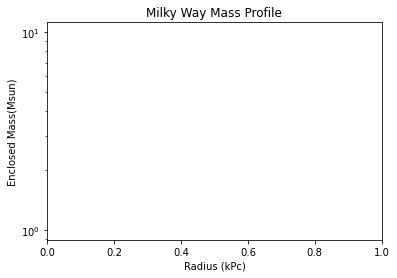

In [20]:
# plotting MW mass profile
plt.title('Milky Way Mass Profile')
plt.xlabel('Radius (kPc)')
plt.ylabel('Enclosed Mass(Msun)')
plt.semilogy(radii, MW_enclosed_mass_Halo, c = 'r',label = 'Halo Mass')
plt.semilogy(radii, MW_enclosed_mass_Disk, c = 'y',label = 'Disk Mass')
plt.semilogy(radii, MW_enclosed_mass_Bulge, c ='g',label = 'Bulge Mass')
plt.semilogy(radii, MW_enclosed_mass_Total, c ='b',label = 'Total Mass')
plt.semilogy(radii, MW_enclosed_mass_Hernquist, c ='o',label = 'Hernquist Mass')
plt.legend()

In [ ]:
# plotting M31 mass profile
plt.title('M31 Mass Profile')
plt.xlabel('Radius (kPc)')
plt.ylabel('Enclosed Mass(Msun)')
plt.semilogy(radii, M31_enclosed_mass_Halo, c = 'r',label = 'Halo Mass')
plt.semilogy(radii, M31_enclosed_mass_Disk, c = 'y',label = 'Disk Mass')
plt.semilogy(radii, M31_enclosed_mass_Bulge, c ='g',label = 'Bulge Mass')
plt.semilogy(radii, M31_enclosed_mass_Total, c ='b',label = 'Total Mass')
plt.semilogy(radii, M31_enclosed_mass_Hernquist, c ='o',label = 'Hernquist Mass')
plt.legend()

In [ ]:
# plotting M33 mass profile
plt.title('M33 Mass Profile')
plt.xlabel('Radius (kPc)')
plt.ylabel('Enclosed Mass(Msun)')
plt.semilogy(radii, M33_enclosed_mass_Halo, c = 'r',label = 'Halo Mass')
plt.semilogy(radii, M33_enclosed_mass_Disk, c = 'y',label = 'Disk Mass')
plt.semilogy(radii, M33_enclosed_mass_Total, c ='b',label = 'Total Mass')
plt.semilogy(radii, M33_enclosed_mass_Hernquist, c ='o',label = 'Hernquist Mass')
plt.legend()

# Velocity Plot


ValueError: x and y must have same first dimension, but have shapes (60,) and (61,)

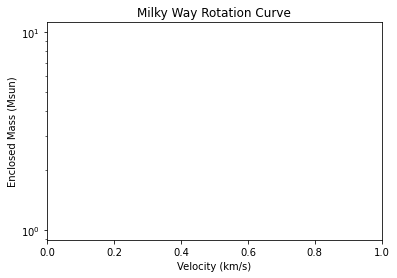

In [22]:
plt.title('Milky Way Rotation Curve')
plt.xlabel('Velocity (km/s)')
plt.ylabel('Enclosed Mass (Msun)')
plt.semilogy(radii, MW_velocity_Halo, 'r', label = "Dark Matter Velocity")
plt.semilogy(radii, MW_velocity_Disk, 'y', label = "Halo Velocity")
plt.semilogy(radii, MW_velocity_Bulge, 'g', label = "Bulge Velocity")
plt.semilogy(radii, MW_velocity_Total, 'b', label = "Total Velocity")
plt.semilogy(radii, MW_velocity_Hernquist, 'o', label = 'Hernquist Velocity')
plt.legend()

ValueError: x and y must have same first dimension, but have shapes (60,) and (61,)

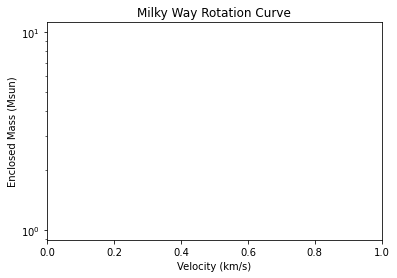

In [23]:
plt.title('M31 Rotation Curve')
plt.xlabel('Velocity (km/s)')
plt.ylabel('Enclosed Mass (Msun)')
plt.semilogy(radii, M31_velocity_Halo, 'r', label = "Dark Matter Velocity")
plt.semilogy(radii, M31_velocity_Disk, 'y', label = "Halo Velocity")
plt.semilogy(radii, M31_velocity_Bulge, 'g', label = "Bulge Velocity")
plt.semilogy(radii, M31_velocity_Total, 'b', label = "Total Velocity")
plt.semilogy(radii, M31_velocity_Hernquist, 'o', label = 'Hernquist Velocity')
plt.legend()

ValueError: x and y must have same first dimension, but have shapes (60,) and (61,)

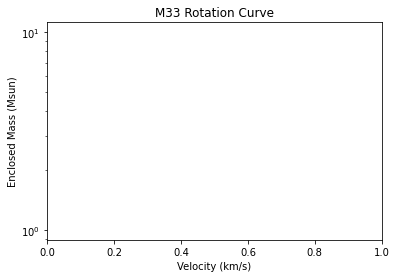

In [24]:
plt.title('M33 Rotation Curve')
plt.xlabel('Velocity (km/s)')
plt.ylabel('Enclosed Mass (Msun)')
plt.semilogy(radii, M33_velocity_Halo, 'r', label = "Dark Matter Velocity")
plt.semilogy(radii, M33_velocity_Disk, 'y', label = "Halo Velocity")
plt.semilogy(radii, M33_velocity_Bulge, 'g', label = "Bulge Velocity")
plt.semilogy(radii, M33_velocity_Total, 'b', label = "Total Velocity")
plt.semilogy(radii, M33_velocity_Hernquist, 'o', label = 'Hernquist Velocity')
plt.legend()